In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 1. Load and Prepare Dataset
def load_airline_passengers_data():
    """
    Load and prepare the Airline Passengers dataset
    """
    # Creating synthetic dataset similar to real Airline Passengers data
    # Mimicking monthly passenger numbers with some growth and seasonality
    np.random.seed(42)
    months = pd.date_range('1949-01-01', '1960-12-31', freq='M')
    base_passengers = 100  # Starting base
    trend = np.linspace(0, 50, len(months))  # Linear growth
    seasonality = 20 * np.sin(np.arange(len(months)) * (2 * np.pi / 12))  # Annual seasonality
    noise = np.random.normal(0, 10, len(months))  # Random noise

    passengers = base_passengers + trend + seasonality + noise
    df = pd.DataFrame({
        'Month': months,
        'Passengers': passengers
    })

    return df

In [2]:
# 2. Data Preprocessing
def preprocess_data(df, look_back=12):
    """
    Preprocess time series data for RNN

    Args:
    - df: DataFrame with time series data
    - look_back: Number of previous time steps to use for prediction

    Returns:
    - Processed data ready for RNN
    """
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_passengers = scaler.fit_transform(df['Passengers'].values.reshape(-1, 1))

    # Prepare sequences
    n_features = 1
    generator = TimeseriesGenerator(
        scaled_passengers,
        scaled_passengers,
        length=look_back,
        batch_size=1
    )

    # Split data
    train_size = int(len(scaled_passengers) * 0.8)
    train_generator = TimeseriesGenerator(
        scaled_passengers[:train_size],
        scaled_passengers[:train_size],
        length=look_back,
        batch_size=16
    )

    test_generator = TimeseriesGenerator(
        scaled_passengers[train_size:],
        scaled_passengers[train_size:],
        length=look_back,
        batch_size=1
    )

    return train_generator, test_generator, scaler, train_size

In [3]:
# 3. Build LSTM Model
def build_lstm_model(look_back=12, n_features=1):
    """
    Create LSTM model for time series prediction

    Args:
    - look_back: Number of previous time steps
    - n_features: Number of input features

    Returns:
    - Compiled Keras model
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(look_back, n_features), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Train and Evaluate Model
def train_and_evaluate_model(train_generator, test_generator, look_back=12):
    """
    Train LSTM model and evaluate performance

    Args:
    - train_generator: Training data generator
    - test_generator: Testing data generator
    - look_back: Number of previous time steps

    Returns:
    - Trained model and training history
    """
    model = build_lstm_model(look_back)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,
        verbose=0
    )

    return model, history

# 5. Make Predictions
def make_predictions(model, test_generator, scaler, train_size, look_back=12):
    """
    Generate predictions and inverse transform

    Args:
    - model: Trained LSTM model
    - test_generator: Test data generator
    - scaler: MinMaxScaler used for normalization
    - train_size: Size of training dataset
    - look_back: Number of previous time steps

    Returns:
    - Actual and predicted values
    """
    # Prepare test data
    X_test, y_test = [], []
    for i in range(len(test_generator)):
        x, y = test_generator[i]
        X_test.append(x[0])
        y_test.append(y[0])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Predict
    predictions = model.predict(X_test)

    # Inverse transform
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)

    return y_test, predictions

<ipython-input-1-66594321f586>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range('1949-01-01', '1960-12-31', freq='M')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Root Mean Squared Error: 11.68359122444336


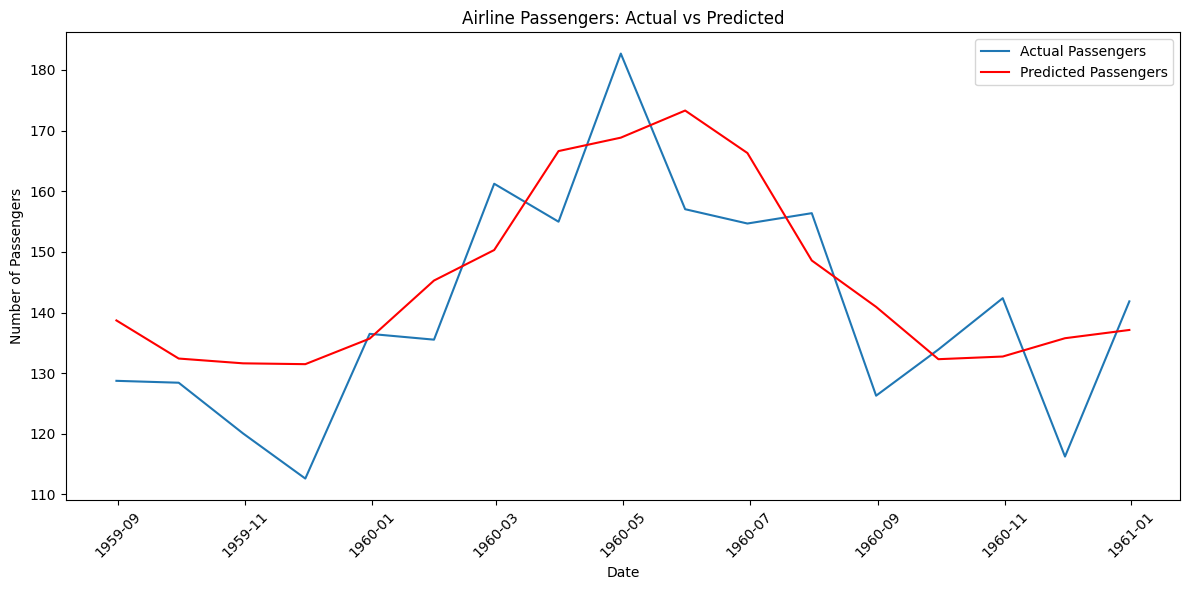

In [4]:
# 6. Visualize Results
def plot_results(df, predictions, train_size, look_back):
    """
    Visualize actual vs predicted values

    Args:
    - df: Original DataFrame
    - predictions: Predicted passenger numbers
    - train_size: Size of training dataset
    - look_back: Number of previous time steps
    """
    plt.figure(figsize=(12, 6))
    plt.plot(
        df['Month'][train_size+look_back:],
        df['Passengers'][train_size+look_back:],
        label='Actual Passengers'
    )
    plt.plot(
        df['Month'][train_size+look_back:],
        predictions,
        color='red',
        label='Predicted Passengers'
    )
    plt.title('Airline Passengers: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main Execution
def main():
    # Load data
    df = load_airline_passengers_data()

    # Preprocessing
    look_back = 12
    train_generator, test_generator, scaler, train_size = preprocess_data(df, look_back)

    # Train model
    model, history = train_and_evaluate_model(train_generator, test_generator, look_back)

    # Predict
    y_test, predictions = make_predictions(model, test_generator, scaler, train_size, look_back)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    print(f'Root Mean Squared Error: {rmse}')

    # Visualize results
    plot_results(df, predictions, train_size, look_back)

if __name__ == "__main__":
    main()